In [648]:
from datetime import datetime
import numpy as np
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [640]:
runs = pd.read_csv('new_strava_data/activities.csv')

runs['Activity Date'] = pd.to_datetime(runs['Activity Date'], format='%b %d, %Y, %I:%M:%S %p')

rel_cols = [
    'Activity Date',
    'Elapsed Time',
    'Distance',
    'Moving Time',
    'Average Heart Rate',
    'Average Speed',
    'Elevation Gain',
    'Average Grade',
    'Grade Adjusted Distance',
]

# Function to calculate HR improvement

In [664]:
def plot_hr_improvement(start_date='2025-02-01', end_date='2025-04-15', title='HR Residual with Linear Trendline'):
    recent_selector = runs['Activity Date'] > start_date
    recent_selector_end = runs['Activity Date'] < end_date
    runs_sub = runs[recent_selector & recent_selector_end][rel_cols]
    runs_sub = runs_sub[~pd.isna(runs_sub['Average Heart Rate'])]
    runs_sub = runs_sub.sort_values('Activity Date')

    # Control for speed + elevation
    X = runs_sub[['Average Speed', 'Elevation Gain']]
    y = runs_sub['Average Heart Rate']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    runs_sub['hr_resid'] = model.resid

    # Linear model
    fig, ax = plt.subplots(figsize=(16, 8))  # Width = 16 inches, Height = 8 inches
    ax.plot(runs_sub['Activity Date'], runs_sub['hr_resid'], label='HR residual')
    
    # Fit linear trendline
    x = runs_sub['Activity Date']
    y = runs_sub['hr_resid']
    x_numeric = x.map(datetime.toordinal)
    z = np.polyfit(x_numeric, y, 1)
    p = np.poly1d(z)
    
    trendline_x = mdates.date2num([datetime.fromordinal(int(val)) for val in x_numeric])
    trendline_y = p(x_numeric)
    ax.plot(trendline_x, trendline_y, color='red', linestyle='--', label='Trendline')
    
    for run_date in runs_sub['Activity Date']:
        ax.axvline(run_date, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
    ax.figure.autofmt_xdate()  # Auto rotates date labels
    ax.legend()
    ax.set_title(title)
    plt.show()

    # Interpret Model
    slope = z[0]  # bpm per day
    intercept = z[1]
    num_days = (x.max() - x.min()).days
    # Compute change in HR residuals over time
    delta_hr = slope * num_days
    print(f"HR improvement over {num_days} days: {delta_hr:.2f} bpm")

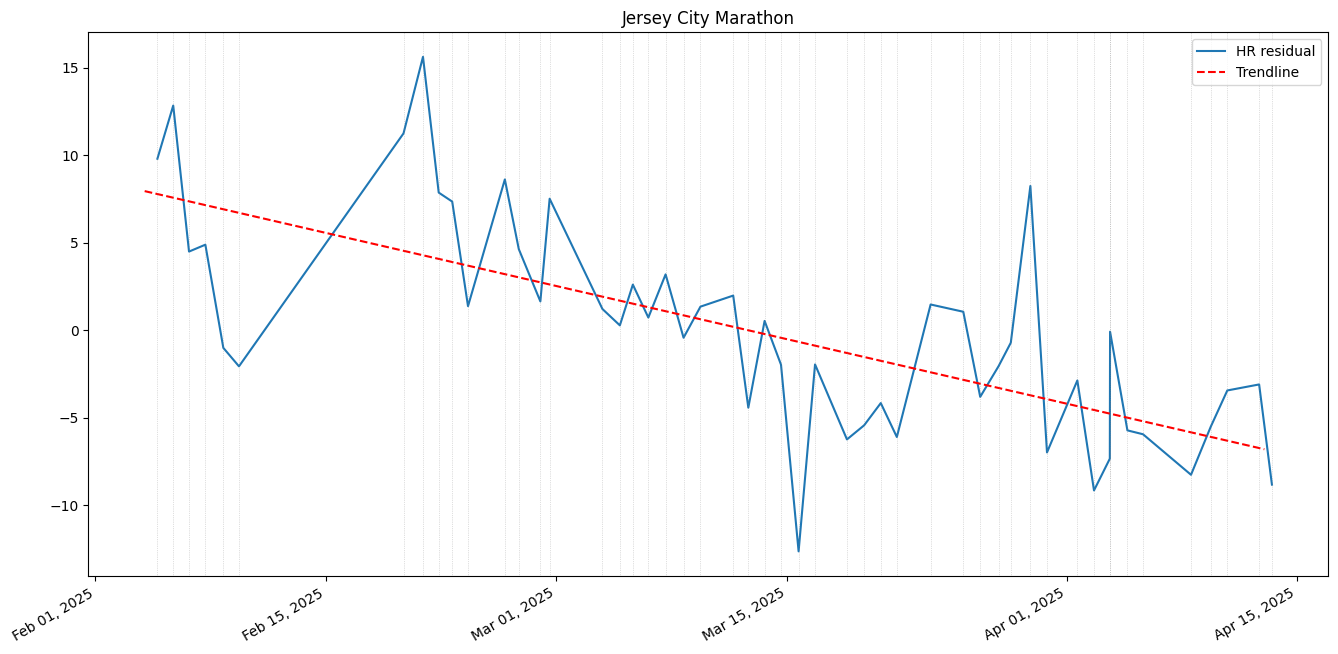

HR improvement over 67 days: -14.53 bpm


In [666]:
plot_hr_improvement(title='Jersey City Marathon')

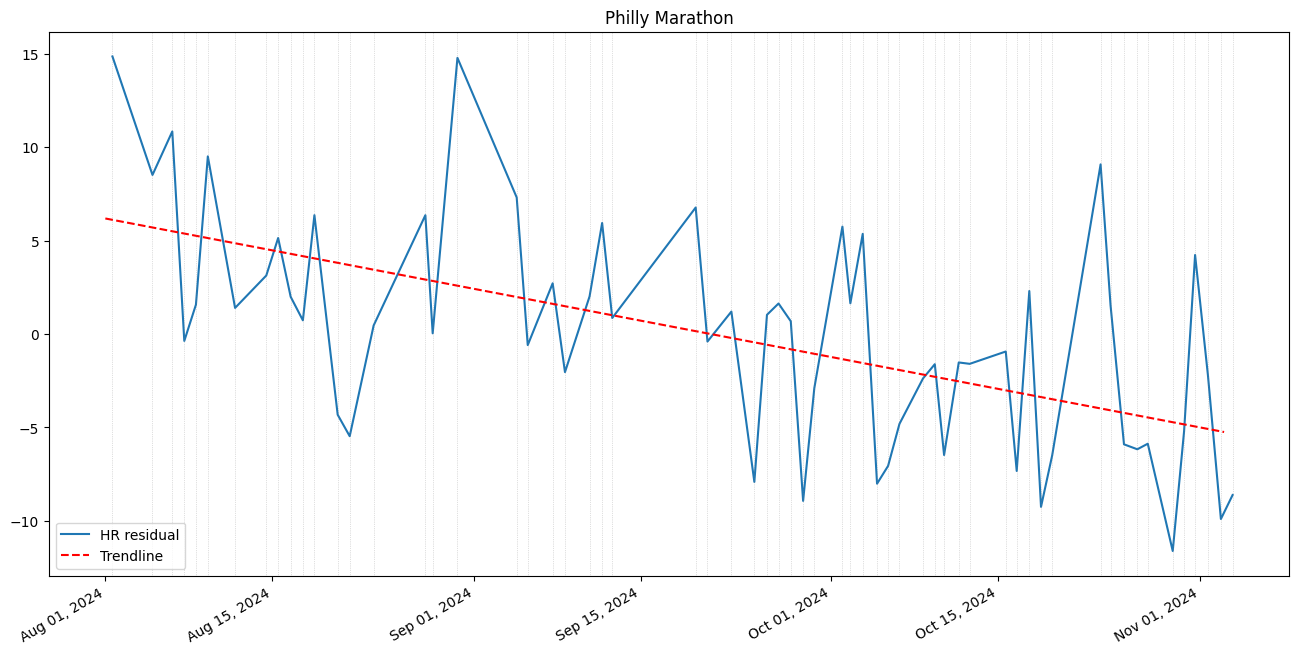

HR improvement over 94 days: -11.43 bpm


In [668]:
plot_hr_improvement('2024-08-01', '2024-11-05', title='Philly Marathon')

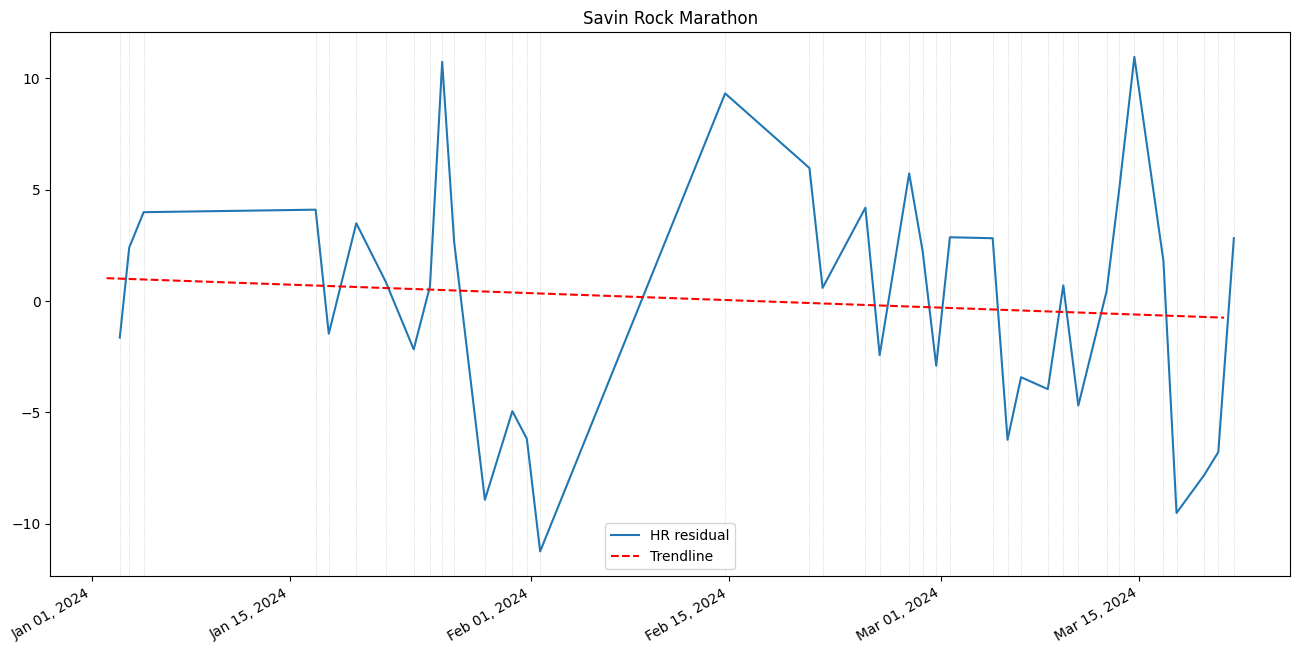

HR improvement over 78 days: -1.75 bpm


In [673]:
plot_hr_improvement('2024-01-01', '2024-03-23', title='Savin Rock Marathon')

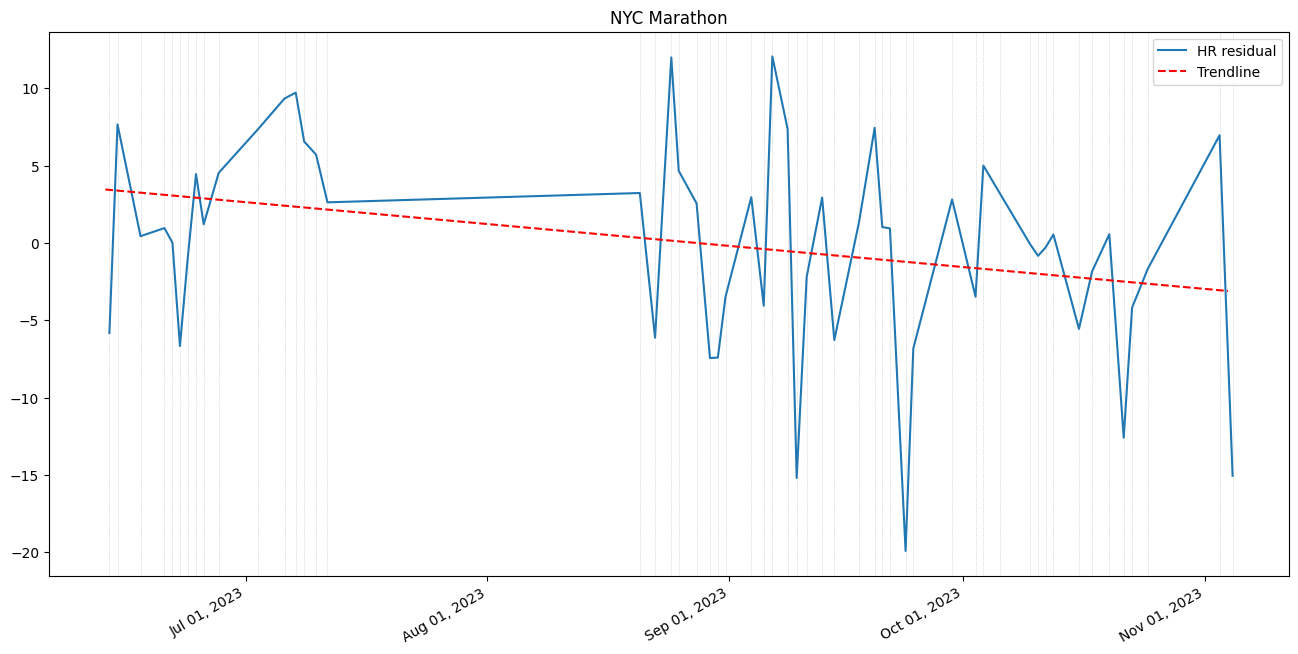

HR improvement over 144 days: -6.56 bpm


In [672]:
plot_hr_improvement('2023-06-01', '2023-11-05', title='NYC Marathon')

# Alternate method using sklearn

In [657]:
from sklearn.linear_model import LinearRegression

# Ensure datetime
runs_sub['Activity Date'] = pd.to_datetime(runs_sub['Activity Date'])

# Define predictors and target
X = runs_sub[['Average Speed', 'Elevation Gain']]
y = runs_sub['Average Heart Rate']

# Fit model
model = LinearRegression()
model.fit(X, y)

# Get model coefficients
intercept = model.intercept_
speed_coef, elev_coef = model.coef_

# Now compare early vs. late runs
# Define early and late periods (or use specific dates)
early = runs_sub[runs_sub['Activity Date'] < '2025-03-01']
late = runs_sub[runs_sub['Activity Date'] >= '2025-03-01']

# Compute mean predicted HR at a standard reference point (e.g., 3.0 m/s, 20 m elevation)
ref_speed = 3.0
ref_elev = 20.0
df = pd.DataFrame({'Average Speed': [ref_speed], 'Elevation Gain': [ref_elev]})
predicted_early = model.predict(df)[0]
predicted_late = late[['Average Speed', 'Elevation Gain']].apply(
    lambda row: model.predict(
        pd.DataFrame({
            'Average Speed': [ref_speed],
            'Elevation Gain': [ref_elev]
        })
    )[0], axis=1
).mean()

# Alternatively: average actual HR at similar speeds for comparison
# Or look at mean residuals
early_residual = early['hr_resid'].mean()
late_residual = late['hr_resid'].mean()

# Output the change
print(f"Model intercept: {intercept:.2f}")
print(f"Speed coefficient: {speed_coef:.2f} bpm per m/s")
print(f"Elevation coefficient: {elev_coef:.2f} bpm per meter")
print(f"\nPredicted HR at {ref_speed} m/s and {ref_elev} m elevation:")
print(f"  Early: {predicted_early:.2f} bpm")
print(f"  Late (mean): {predicted_late:.2f} bpm")
print(f"\nChange in residuals (Actual - Predicted):")
print(f"  Early residual: {early_residual:.2f} bpm")
print(f"  Late residual: {late_residual:.2f} bpm")
print(f"  Δ Residual: {late_residual - early_residual:.2f} bpm")

Model intercept: 89.30
Speed coefficient: 20.78 bpm per m/s
Elevation coefficient: 0.01 bpm per meter

Predicted HR at 3.0 m/s and 20.0 m elevation:
  Early: 151.84 bpm
  Late (mean): 151.84 bpm

Change in residuals (Actual - Predicted):
  Early residual: 6.31 bpm
  Late residual: -2.71 bpm
  Δ Residual: -9.02 bpm
